In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle

# Load the data
df = pd.read_csv('Data_v.3.csv')

# df.fillna(0, inplace=True)
# mask = df['Category'] == 'Tourist attraction'
# df = df[~mask].reset_index(drop=True)

df


2024-06-03 06:55:15.536677: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 06:55:15.539702: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-03 06:55:15.582176: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 06:55:16.374489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Hiburan,Jakarta,270000,4.6,-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Hiburan,Jakarta,10000,4.5,-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Hiburan,Jakarta,94000,4.5,-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...
686,687,Teluk Kiluan,Teluk terkenal dengan atraksi lumba-lumba di L...,alam,Tangamus,0,4.6,-5.779489,105.093217
687,688,Pantai Tanjung Setia,Pantai dengan ombak besar untuk berselancar di...,alam,Pesisir Selatan,0,4.5,-5.302336,103.999850
688,689,Pantai Dewi Mandapa,Pantai dengan pemandangan indah dan fasilitas ...,alam,Pesarawan,0,3.9,-5.572197,105.243705
689,690,Bendungan Margotirto,Bendungan dengan pemandangan alam yang indah d...,alam,Tangamus,0,4.3,-5.421126,104.725779


In [2]:
# Encode categorical features
category_encoder = LabelEncoder()
city_encoder = LabelEncoder()
df['Category_Encoded'] = category_encoder.fit_transform(df['Category'])
df['City_Encoded'] = city_encoder.fit_transform(df['City'])

# Retain original price and rating
original_price = df['Price'].values
original_rating = df['Rating'].values

# Normalize numerical features
scaler = MinMaxScaler()
df[['Price', 'Rating', 'Lat', 'Long']] = scaler.fit_transform(df[['Price', 'Rating', 'Lat', 'Long']])

# Combine numerical features with categorical features
features = np.hstack((df[['Category_Encoded', 'City_Encoded', 'Price', 'Rating', 'Lat', 'Long']].values,))

# Define the model using Sequential API
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.1), input_shape=(features.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.1)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(features.shape[1], activation='relu', kernel_regularizer=l2(0.01))
])

# model = Model(inputs=input_layer, outputs=embedding_output)

# Define Adam optimizer with custom learning rate
learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
model.summary()

# Lists to store MSE values
mse_values = []

# Train the model
epochs = 100
batch_size = 32
for epoch in range(epochs):
    history = model.fit(features, features, epochs=1, batch_size=batch_size, verbose=1)
    
    # Append MSE value
    mse_values.append(history.history['loss'][0])
    print(f'Epoch {epoch + 1}/{epochs} - MSE: {mse_values[-1]}')

# Get the embeddings
embeddings = model.predict(features)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

/home/rofid/Documents/Bangkit/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,430 (44.65 KB)

 Trainable params: 11,430 (44.65 KB)

 Non-trainable params: 0 (0.00 B)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 264.0355
Epoch 1/100 - MSE: 263.2193298339844
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 259.6264
Epoch 2/100 - MSE: 260.7045593261719
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 262.2369
Epoch 3/100 - MSE: 259.0627136230469
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 265.6557 
Epoch 4/100 - MSE: 257.8683776855469
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 251.7949 
Epoch 5/100 - MSE: 257.0035095214844
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 256.0328
Epoch 6/100 - MSE: 256.3754577636719
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 248.8653 
Epoch 7/100 - MSE: 255.9180145263672
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 257.6118 
Epoch 8/100 - MSE: 255.58041381835938
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 260.8506
Epoch 9/100 - MSE: 255.32762145996094
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 239.6528 
Epoch 10/100 - MSE: 255.1347198486328
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 247.249

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 252.2898
Epoch 64/100 - MSE: 253.90756225585938
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 258.3376 
Epoch 65/100 - MSE: 253.9056854248047
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 253.0537 
Epoch 66/100 - MSE: 253.90380859375
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 246.2409
Epoch 67/100 - MSE: 253.9020233154297
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 249.0416 
Epoch 68/100 - MSE: 253.90023803710938
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 253.2883 
Epoch 69/100 - MSE: 253.8986358642578
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 255.6795
Epoch 70/100 - MSE: 253.89700317382812
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 248.2520 
Epoch 71/100 - MSE: 253.8955535888672
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 252.0859
Epoch 72/100 - MSE: 253.89410400390625
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 258.5228
Epoch 73/100 - MSE: 253.8926544189453
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step -

#### jika consider lat and long

In [3]:
# def recommend(place_id, top_n=5):
#     idx = df.index[df['Place_Id'] == place_id].tolist()[0]
#     place_name = df.loc[idx, 'Place_Name']
#     place_category = df.loc[idx, 'Category']
#     place_lat = df.loc[idx, 'Lat']
#     place_long = df.loc[idx, 'Long']
#     place_embedding = embeddings[idx]

#     # Calculate geographic distances
#     distances = df.apply(lambda row: great_circle((place_lat, place_long), (row['Lat'], row['Long'])).kilometers, axis=1)

#     # Filter places with the same category and within a certain distance (e.g., 50 km)
#     filtered_df = df[(df['Category'] == place_category) & (distances <= 50)]
#     filtered_indices = filtered_df.index
#     filtered_embeddings = embeddings[filtered_indices]

#     similarities = np.dot(filtered_embeddings, place_embedding)
#     recommended_indices = filtered_indices[np.argsort(similarities)[::-1][1:top_n+1]]
#     recommended_places = df.iloc[recommended_indices]

#     # Sort recommended places by price and rating
#     recommended_places = recommended_places.sort_values(by=['Price', 'Rating'], ascending=[True, False])

#     # Restore original price and rating
#     recommended_places['Price'] = original_price[recommended_indices]
#     recommended_places['Rating'] = original_rating[recommended_indices]

#     print(f"Similar places to {place_name} in the {place_category} category within 50 km:")
#     print(recommended_places[['Place_Name', 'Category', 'Lat', 'Long', 'Price', 'Rating']])

#     return recommended_places[['Place_Name', 'Category', 'Lat', 'Long', 'Price', 'Rating']]

#### jumlah kota dibatasi

In [42]:
# def recommend(place_id, top_n=5):
#     idx = df.index[df['Place_Id'] == place_id].tolist()[0]
#     place_name = df.loc[idx, 'Place_Name']
#     place_category = df.loc[idx, 'Category']
#     place_city = df.loc[idx, 'City']
#     place_embedding = embeddings[idx]

#     # Filter places with the same category and different city
#     filtered_df = df[(df['Category'] == place_category) & (df['City'] != place_city)]
#     filtered_indices = filtered_df.index
#     filtered_embeddings = embeddings[filtered_indices]

#     similarities = np.dot(filtered_embeddings, place_embedding)
#     recommended_indices = filtered_indices[np.argsort(similarities)[::-1]]

#     # Restrict recommendations to maximum 2 places per city
#     city_counts = {}
#     recommended_places = []
#     for index in recommended_indices:
#         city = df.loc[index, 'City']
#         if city not in city_counts:
#             city_counts[city] = 0
#         if city_counts[city] < 2:
#             recommended_places.append(index)
#             city_counts[city] += 1
#         if len(recommended_places) >= top_n:
#             break

#     # If less than top_n places are recommended, add places from other cities
#     if len(recommended_places) < top_n:
#         additional_places = filtered_df[~filtered_df.index.isin(recommended_places)].index[:top_n - len(recommended_places)]
#         recommended_places.extend(additional_places)

#     recommended_places = df.iloc[recommended_places]

#     # Sort recommended places by price and rating
#     recommended_places = recommended_places.sort_values(by=['Price', 'Rating'], ascending=[True, False])

#     # Restore original price and rating
#     recommended_places['Price'] = original_price[recommended_places.index]
#     recommended_places['Rating'] = original_rating[recommended_places.index]

#     print(f"Similar places to {place_name} in {place_city} in the {place_category} category from different cities:")
#     print(recommended_places[['Place_Name', 'Category', 'City', 'Price', 'Rating']])

#     return recommended_places[['Place_Name', 'Category', 'City', 'Price', 'Rating']]

#### tidak consider city

In [13]:
# def recommend(place_id, top_n=5):
#     idx = df.index[df['Place_Id'] == place_id].tolist()[0]
#     place_name = df.loc[idx, 'Place_Name']
#     place_category = df.loc[idx, 'Category']
#     place_embedding = embeddings[idx]

#     # Filter places with the same category
#     filtered_df = df[df['Category'] == place_category]
#     filtered_indices = filtered_df.index
#     filtered_embeddings = embeddings[filtered_indices]

#     similarities = np.dot(filtered_embeddings, place_embedding)
#     recommended_indices = filtered_indices[np.argsort(similarities)[::-1][1:top_n+1]]
#     recommended_places = df.iloc[recommended_indices]

#     # Sort recommended places by price and rating
#     recommended_places = recommended_places.sort_values(by=['Price', 'Rating'], ascending=[True, False])

#     # Restore original price and rating
#     recommended_places['Price'] = original_price[recommended_indices]
#     recommended_places['Rating'] = original_rating[recommended_indices]

#     print(f"Similar places to {place_name} in the {place_category} category:")
#     print(recommended_places[['Place_Name', 'Category', 'City', 'Price', 'Rating']])

#     return recommended_places[['Place_Name', 'Category', 'City','Price', 'Rating']]

#### consider city

In [14]:
# def recommend(place_id, top_n=5):
#     idx = df.index[df['Place_Id'] == place_id].tolist()[0]
#     place_name = df.loc[idx, 'Place_Name']
#     place_category = df.loc[idx, 'Category']
#     place_city = df.loc[idx, 'City']
#     place_embedding = embeddings[idx]
    
#     # Filter places with the same category and city as the input place
#     same_category_city_df = df[(df['Category'] == place_category) & (df['City'] == place_city)]
#     same_category_city_indices = same_category_city_df.index
#     same_category_city_embeddings = embeddings[same_category_city_indices]
    
#     similarities = np.dot(same_category_city_embeddings, place_embedding)
#     recommended_indices = same_category_city_indices[np.argsort(similarities)[::-1][1:top_n+1]]
#     recommended_places = df.iloc[recommended_indices]
    
#     # Sort recommended places by price and rating
#     recommended_places = recommended_places.sort_values(by=['Price', 'Rating'], ascending=[True, False])
    
#     # Restore original price and rating
#     recommended_places['Price'] = original_price[recommended_indices]
#     recommended_places['Rating'] = original_rating[recommended_indices]

#     # Sort recommended places by price and rating
#     recommended_places = recommended_places.sort_values(by=['Price', 'Rating'], ascending=[True, False])

#     print(f"Similar places to {place_name} in the {place_category} category and {place_city} city:")
#     print(recommended_places[['Place_Name', 'Category', 'City', 'Price', 'Rating']])

#     return recommended_places[['Place_Name', 'Category', 'City', 'Price', 'Rating']]


#### mengutamakan lat dan long

In [53]:
def recommend(place_id, top_n=5):
    idx = df.index[df['Place_Id'] == place_id].tolist()[0]
    place_name = df.loc[idx, 'Place_Name']
    place_category = df.loc[idx, 'Category']
    place_city = df.loc[idx, 'City']
    place_lat = df.loc[idx, 'Lat']
    place_long = df.loc[idx, 'Long']
    place_embedding = embeddings[idx]

    # Filter places with the same category and different city
    filtered_df = df[(df['Category'] == place_category) & (df['City'] != place_city)]
    filtered_indices = filtered_df.index
    filtered_embeddings = embeddings[filtered_indices]

    # Calculate distance from input place
    distances = filtered_df.apply(lambda row: geodesic((place_lat, place_long), (row['Lat'], row['Long'])).kilometers, axis=1)

    # Sort filtered places by distance
    filtered_df['Distance'] = distances
    filtered_df = filtered_df.sort_values(by='Distance')

    # Get recommended places from nearest cities
    recommended_indices = filtered_df.index[:top_n]

    # If less than top_n places are recommended, add places from other cities
    if len(recommended_indices) < top_n:
        additional_places = filtered_df[~filtered_df.index.isin(recommended_indices)].index[:top_n - len(recommended_indices)]
        recommended_indices = np.concatenate((recommended_indices, additional_places))

    recommended_places = df.iloc[recommended_indices]

    # Restore original price and rating
    recommended_places['Price'] = original_price[recommended_places.index]
    recommended_places['Rating'] = original_rating[recommended_places.index]

    print(f"Similar places to {place_name} in {place_city} in the {place_category} category:")
    print(recommended_places[['Place_Name', 'Category', 'City', 'Lat', 'Long', 'Price', 'Rating']])

    return recommended_places[['Place_Name', 'Category', 'City', 'Lat', 'Long', 'Price', 'Rating']]


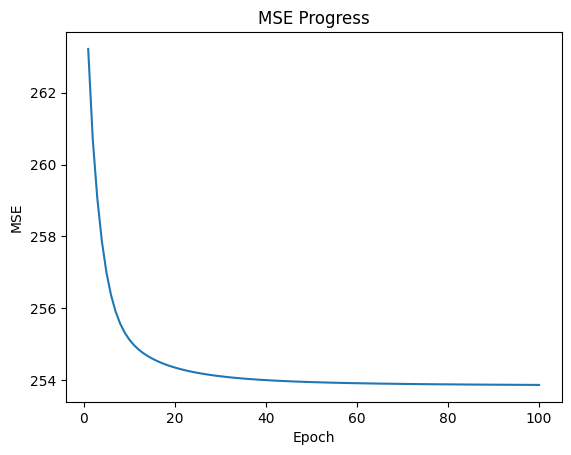

In [15]:
# Plot MSE progress
plt.plot(range(1, epochs + 1), mse_values)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE Progress')
plt.show()

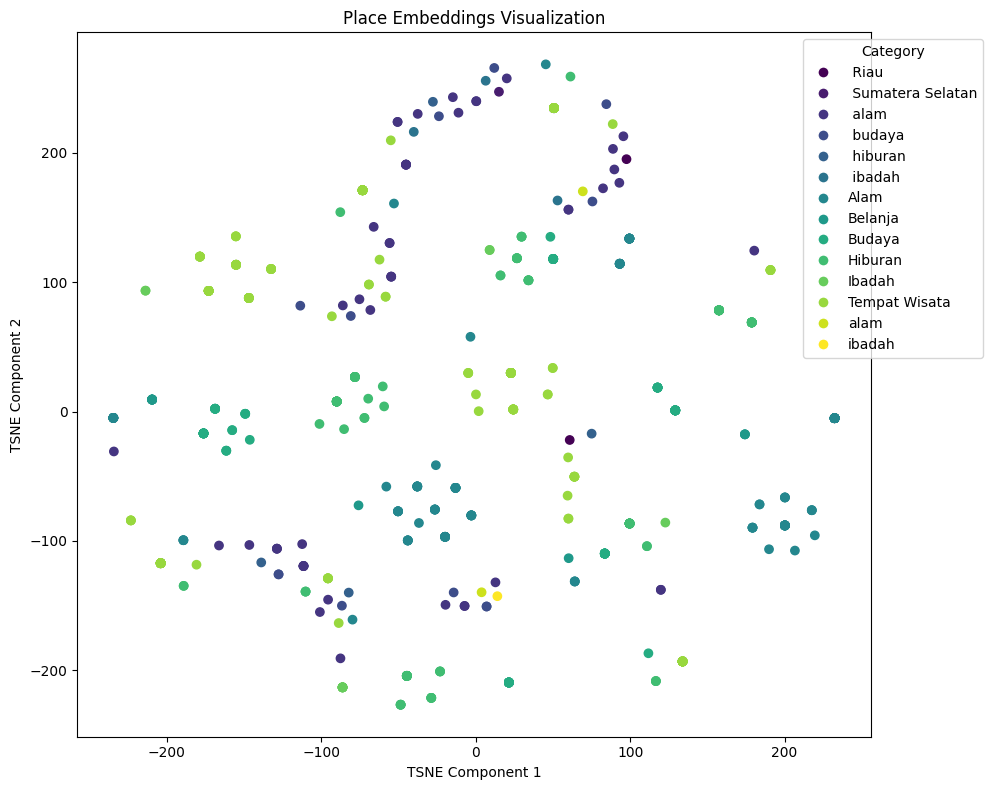

In [24]:
# Visualization using TSNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['Category_Encoded'], cmap='viridis')

# Create a legend with category labels and colors
legend_labels = category_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), 
                              markersize=8) for i in range(len(legend_labels))]
plt.legend(legend_handles, legend_labels, title='Category', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Place Embeddings Visualization')
plt.tight_layout()
plt.show()

In [58]:
# Get user input for Place_Id
place_id = int(input("Enter the Place_Id: "))

# Get recommendations for the input Place_Id
recommendations = recommend(place_id)
# print(recommendations)

Enter the Place_Id: 655
Similar places to Taman Wisata Jambi Paradise in Muaro Jambi in the  hiburan category:
              Place_Name  Category             City       Lat      Long  \
666         Wahana Surya   hiburan  Bengkulu Tengah  0.317629  0.366186   
652     Palm Spring Golf   hiburan            Batam  0.665194  0.462440   
634  Rahmat Zoo and Park   hiburan  Serdang Bedagai  0.830109  0.197082   

     Price  Rating  
666      0     4.1  
652      0     4.8  
634      0     4.4  


/tmp/ipykernel_316673/4113214458.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Distance'] = distances
/tmp/ipykernel_316673/4113214458.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_places['Price'] = original_price[recommended_places.index]
/tmp/ipykernel_316673/4113214458.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [10]:
## # Save the trained model
# model.save('recommendation_model.h5')